# Проект Предсказание температуры металла

Исполнитель: Троицкий Илья  
Дата: 1 сентября 2023 г.  

### Описание проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание данных
Данные состоят из файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Импорт библиотек и настроек

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

In [2]:
pd.options.mode.chained_assignment = None
matplotlib.rc('figure', figsize=(10, 5))
sns.set_palette("pastel")

### Описание констант и функций

In [3]:
EMISSIION_IQR_TRASHOLD = 3
RANDOM_STATE = 10923
TEST_SIZE = 0.25

In [4]:
def dataframe_info(df):
    
    # Общая информация
    display(df.head())
    display(df.info())
    display(df.describe())
    print('DUPLICATES:', df.duplicated().sum())

    # Боксплоты числовых колонок
    
    num_cols = df.select_dtypes(np.number).columns.tolist()
    
    i = 0
    fig = plt.figure(figsize=(10,10))
    
    for col in num_cols:

        fig.add_subplot(4, 4, i+1)
        sns.boxplot(data=df[col])
        plt.xlabel(col)
        plt.tight_layout()
        i+=1

def delete_emissions(data, col, **kwargs):
    q1 = data[col].quantile(0.25)   
    q3 = data[col].quantile(0.75)
    iqr = q3-q1

    if 'iqr_k' in kwargs:
        iqr_k = kwarg['iqr_k']
    else:
        iqr_k = EMISSIION_IQR_TRASHOLD
            
    if 'min' in kwargs:
        min = kwargs['min']
    else:
        min = q1 - iqr*iqr_k

    if 'max' in kwargs:       
        max = kwargs['max']
    else:
        max = q3 + iqr*iqr_k    
    
    return data[(data[col] >= min) & (data[col] <= max)]      

### Загрузка данных

In [5]:
if (os.path.exists('/datasets')):
    path = '/datasets'
elif (os.path.exists('datasets')):
    path = 'datasets'
else:    
    raise Exception('Не найден файл с данными.')    

data_arc = pd.read_csv(f'{path}/data_arc_new.csv', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk = pd.read_csv(f'{path}/data_bulk_new.csv')
data_bulk_time = pd.read_csv(f'{path}/data_bulk_time_new.csv')
data_gas= pd.read_csv(f'{path}/data_gas_new.csv')
data_temp = pd.read_csv(f'{path}/data_temp_new.csv', parse_dates = ['Время замера'])
data_wire = pd.read_csv(f'{path}/data_wire_new.csv')
data_wire_time = pd.read_csv(f'{path}/data_wire_time_new.csv')
print('Данные успешно загружены.')


Данные успешно загружены.


## Анализ данных

### Данные об электродах

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


DUPLICATES: 0


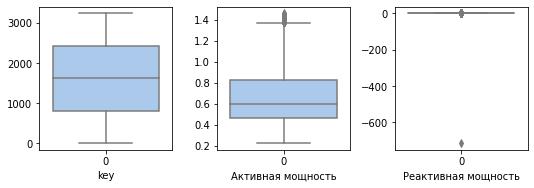

In [6]:
dataframe_info(data_arc)

In [7]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [8]:
data_arc[data_arc['key'] == 2108].head(16)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9734,2108,2019-07-27 10:41:13,2019-07-27 10:43:28,0.682359,0.536962
9735,2108,2019-07-27 11:07:24,2019-07-27 11:08:51,0.786992,0.582873
9736,2108,2019-07-27 11:13:37,2019-07-27 11:14:32,0.525551,0.329251
9737,2108,2019-07-27 11:15:45,2019-07-27 11:16:45,1.175194,0.789164
9738,2108,2019-07-27 11:19:26,2019-07-27 11:21:24,0.671852,0.508570
9739,2108,2019-07-27 11:23:12,2019-07-27 11:26:07,0.325151,0.217883
9740,2108,2019-07-27 13:39:32,2019-07-27 13:43:14,0.412624,0.278039
9741,2108,2019-07-27 13:45:19,2019-07-27 13:48:19,0.798390,0.616971
9742,2108,2019-07-27 13:49:36,2019-07-27 13:57:40,0.327366,0.239850
9743,2108,2019-07-27 14:01:23,2019-07-27 14:05:24,1.233412,0.855522


<AxesSubplot:>

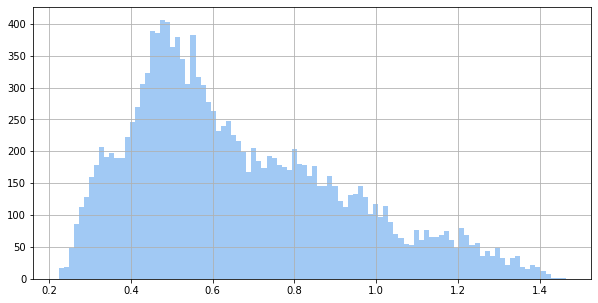

In [9]:
data_arc['Активная мощность'].hist(bins=100)

In [10]:
data_arc[data_arc['Реактивная мощность'] < 0].head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


<AxesSubplot:>

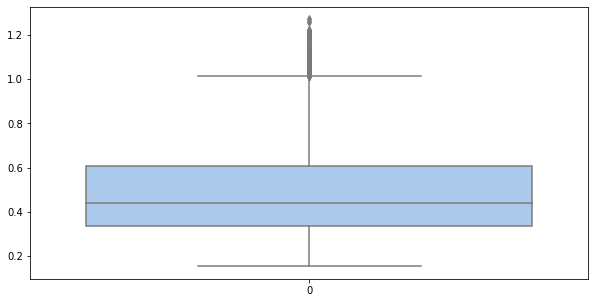

In [11]:
sns.boxplot(data=data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'])

<AxesSubplot:>

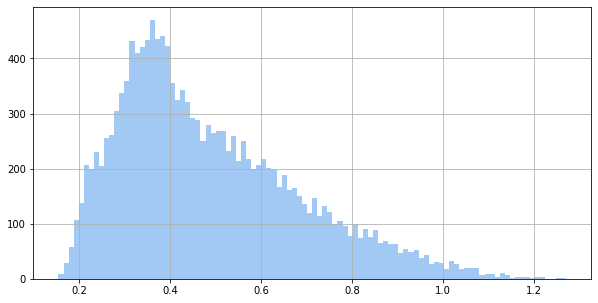

In [12]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100)

#### Вывод
В выборке данные по 3241 партии. По одной партии может бытьт несколько записей, в зависимости от продолжительности операции.  Самая длительная операция длилась почти 6 часов и имеет 16 записей. Показатель `Активная мощность` находится в пределах от 0 до 1,5 с пиков в отрезке 0.4-0.6. В показателе `Реактивная мощность` имеется выброс со значением -715.479924, что скорей всего является ошибкой датчика. Исключая эту строку, остальные значения лежат в диапазоне 0 - 1.3 с пиков в отрезке 0.3-0.4.

Вопросы:
1. Нормальна ли операция в 6 часов над одной партией?
2. Что такое Активная и Реактивная мощность? 
3. В чем измеряется мощность?
4. Верно ли я понял, что этот показатель показывает с какой мощностью работал электрод в указанный период замера и в будущем, чтобы получить количество затраченной энергии надо будет умножать мощность на время работы.  

### Данные о подаче сыпучих материалов

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


DUPLICATES: 0


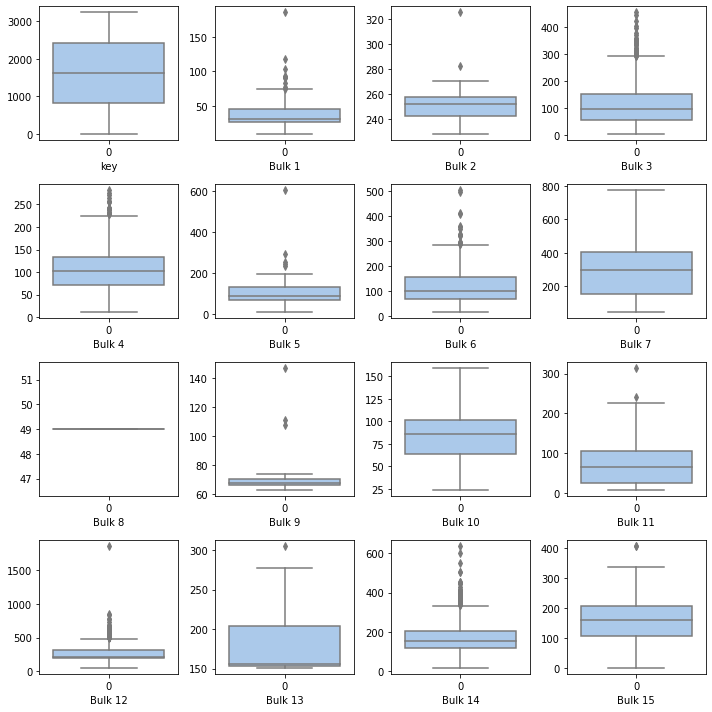

In [13]:
dataframe_info(data_bulk)

In [14]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

In [15]:

def find_missing(lst):
	
	arr = np.array(lst)
	full_range = np.arange(lst[0], lst[-1]+1)
	missing = np.setdiff1d(full_range, arr)
	
	return missing.tolist()

missing = find_missing(data_bulk['key'].tolist())
print("Партии по которым нет данных: ", missing)


Партии по которым нет данных:  [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


DUPLICATES: 0


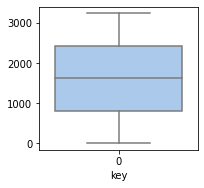

In [16]:
dataframe_info(data_bulk_time)

In [17]:
missing = find_missing(data_bulk_time['key'].tolist())
print("Партии по которым нет данных: ", missing)

Партии по которым нет данных:  [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


#### Вывод
Данные о подаче сыпучих материалов представлены двумя таблицами:
- объем подаваемого сырья
- время подаваемого сырья
По некоторым партиям данные отсутствую. Данные по некоторым bulk встречаются очень редко, например bulk8 представлен всего одной записью.

Вопросы:
1. С какой скоростью подается сырье? если всегда с одинаковой, то данные по времени подачи нам не нужны. Но может быть и так, что скорость подачи сырья вляет на качество смеси.
2. Разныые бункеры для разных материалов? Если есть одинаковые, их можно объединить.
3. Почему по некоторым партиям нет данных?
4. Почему есть выбросы в показателях? Связано это с ошибкой замеров или это было сделано умышленно.

### Данные о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


DUPLICATES: 0


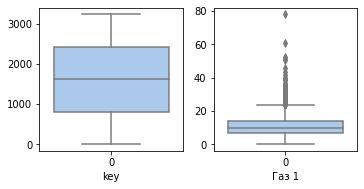

In [18]:
dataframe_info(data_gas)

In [19]:
missing = find_missing(data_gas['key'].tolist())
print("Партии по которым нет данных: ", missing)

Партии по которым нет данных:  [193, 259]


#### Вывод
Только по двум партиям нет данных о продувке газом. Показетель продувкки находится в диапазоне от 0 до 78, 50% значений попадют в интервал 7.04 - 13.76

Вопросы:
1. Выяснить природу выбросов 
2. Выяснить причину отсутсвия данных

### Данные о замере температуры

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


DUPLICATES: 0


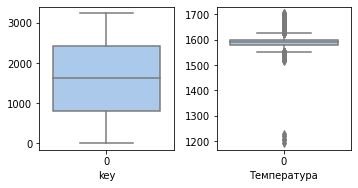

In [20]:
dataframe_info(data_temp)

In [21]:
data_temp['key'].value_counts(dropna=False)

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

In [22]:
len(pd.unique(data_temp['key']))

3216

#### Вывод
По нескольким партиям нет данных о температуре. По одной партии производится несколько замеров.

Вопросы:
1. Выяснить природу выбросов 
2. Выяснить причину отсутсвия данных (пропусков)
3. Выяснить от чего зависит начальная температура сплава. Если сплав поступает с разной температурой , то показатель начальной температуры надо включить в признаки.
4. Конечная температура - целевой признак.

### Данные о проволочных материалах

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


DUPLICATES: 0


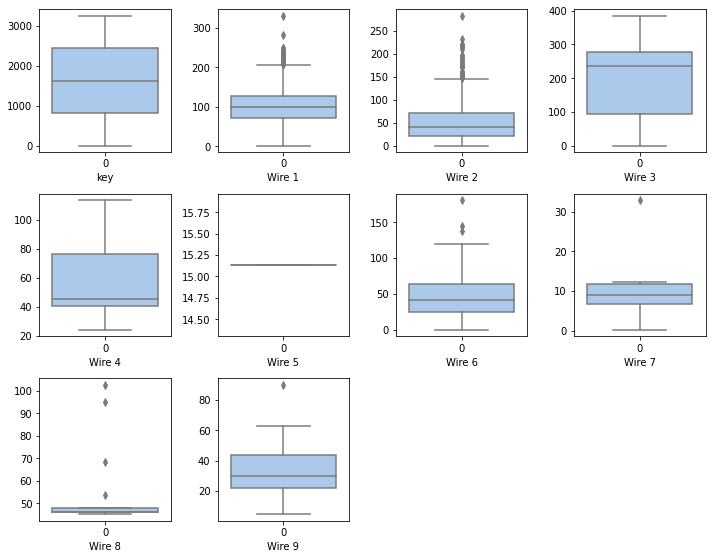

In [23]:
dataframe_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


DUPLICATES: 0


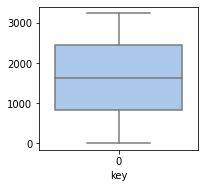

In [24]:
dataframe_info(data_wire_time)

#### Вывод
Данные о подаче проволочных материалов представлены двумя таблицами: с объемом и временем подачи. Одна партия - одна стока с данными. По нескольким партиям нет данных о подаче проволочных материалов. 

Вопросы:
1. Выяснить природу выбросов 
2. Выяснить причину отсутсвия данных (пропусков)
3. Выяснить скорость подачи материала, если она одинаковая, данные о времени подачи необходимо исключить.
4. Выяснить, почему по некоторым материалам очень мало данных о подаче, возможно их можно исключить как незначительные факторы для прогноза.

## Список вопросов
Полый список вопросов представлены выше. Перечислю основные типы вопросов.
1. Разобраться в природе выбросов, это ошибка или они обусловленных особенностями тех. процесса.
2. Выяснить причину отсутствия данных по некоторым партиям и принять решения об исключении этих парти из данных обучения.
3. Выяснить какие фактор оказывают незначительное влияние на тех процесс (время подачи материала, объем некототрых материалов), чтобы их исключить.
4. Как поступать с данными, которые присутствуют в нескольких экземплярых для партии (брать сумму показатель, мин/макс или среднее значение)
5. Разобратьтся с особенностями тех процесса: Мощность, замер температуры, скорость подачи материала.
6. Правильно ли мы определили целевой признак - температура при окончании процесса.

## План решения задачи

После того, как получим ответы на все вопросы.

1. Исключить лишние данные
- выбросы
- партии без данных
- факторы, которые не оказывают или оказывают слабое влияние на финальную температуру

2. Обработка данных
- переименовать столбцы в соответствтии с правилами наименования
- удалить выбросы
- удалить партии без данных 
- агрегировать данные по номеру партии. Способ агрегации выбрать после ответов на вопросы.
- соединить все данные в одну таблицу

3. Обучение модели
Взять несколько моделей регрессис, обучить их на трейн данных с кроссвалидацией и перебором метапараметров.



## ЭТАП 2. Обработка данных

### Данные электродов

Таблицу с нагревом электродов преобразуем следующим образом:
1. Добавим колонку с полной мощностью, рассчитанной по формуле
$$
  S = \sqrt{(P^2 + Q^2)}
$$
Где P - Активная мощность, а Q - реактивная мощность

In [25]:
arc = data_arc[(data_arc['Активная мощность'] > 0) & (data_arc['Реактивная мощность'] > 0)]
arc['full_power'] = np.sqrt(np.power(arc['Активная мощность'], 2) + np.power(arc['Реактивная мощность'], 2))
#data_arc["t_arc"] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
#data_arc["t_arc"] = data_arc["t_arc"].dt.seconds


Так как точность физических расчетов для текущей задачи не важна, то допустим, что параметр характеризующий затраченную энергию эквивалентен сумме мощностей всех измерений. Поэтому следующий шаг:
2. Удалим остальные колонки, просуммируем мощность измерений по партии (key)

In [26]:
arc = arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'], axis=1)
arc = arc.groupby(by='key', as_index=True).agg({'full_power' : ['sum','count']}) 
arc.columns = ['full_power', 'iterations']
display(arc.head())
display(arc[arc['full_power']<0.1]) # проверим, нет ли околонулевых значений


,full_power,iterations
key,,
1,3.718736,5
2,2.588349,4
3,5.019223,5
4,3.400038,4
5,2.816980,4


,full_power,iterations
key,,


### Подача сыпучих
1. Заменяем NaN нулями
2. Убираем выбросы, которые находятся за IQR *3

In [27]:
bulk = data_bulk.fillna(0)
bulk = bulk.set_index('key',drop=True)
print(bulk.shape)
bulk.head()

(3129, 15)


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


На этапе удаления выбросов, выбрасывались почти все партии, в процессе которых участвовали редкие bulk. Принял решение попробовать обучить с выбросами, и вернуться к этому если качество обучения будет неудовлетворительным

In [28]:
#for col in bulk.columns:
#   bulk = delete_emissions(bulk, col, min=0)

### Продувка сплава
1. Удаляем выбросы

In [29]:
gas = data_gas.set_index('key',drop=True)
gas.columns = ['gas']
gas = delete_emissions(gas, 'gas', min=0, max=60) 
print(gas.shape)

(3237, 1)


### Температура сплава
1. Удалить выбросы, в том числе те строки, у которых финальная температура ниже температуры плавления сплава = 1450
2. Агрегируем данные по партии, берём начальную температуру из первого замера и финальную из последнего

In [30]:
temp = data_temp.fillna(0)
temp = temp.groupby(by='key', as_index=True).agg({'Температура' : ['first','last']})
temp.columns = ['t0', 't1']
print(temp.shape)
temp.head()

(3216, 2)


,t0,t1
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [31]:
temp = delete_emissions(temp, 't0', min=1450)
temp = delete_emissions(temp, 't1', min=1450)
print(temp.shape)

(2451, 2)


In [32]:
temp

,t0,t1
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


### Подача провода

1. удаляем выбросы

In [33]:
wire = data_wire.fillna(0)
wire = wire.set_index('key', drop=True)
wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Объединяем таблицы
Объединяем таблицы в одну, использая внутреннее соединение, так как нам не нужны партии, по которым отсутствуют некоторые данные

In [34]:
d = arc \
    .merge(bulk, left_index=True, right_index=True) \
    .merge(gas, left_index=True, right_index=True) \
    .merge(temp, left_index=True, right_index=True) \
    .merge(wire, left_index=True, right_index=True) 
print(d.shape)
print(d.columns)
d.head()    

(2323, 29)
Index(['full_power', 'iterations', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gas', 't0', 't1', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9'],
      dtype='object')


,full_power,iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,t1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.588349,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.019223,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.400038,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.816980,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляции


In [35]:
d.corr().unstack()[(d.corr().unstack() < 1) & (abs(d.corr().unstack()) >= 0.9)]

Bulk 9  Wire 8    0.973817
Wire 8  Bulk 9    0.973817
dtype: float64

In [36]:
d = d.drop('Bulk 9', axis=1)

### Подготовка данных для обучения и тестирования

In [37]:
features = d.drop('t1', axis=1)
target = d['t1']

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=TEST_SIZE)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1742, 27)
(1742,)
(581, 27)
(581,)


## Обучение моделей

### Linenar regression

In [38]:
%%time 

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns),
    ])


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                    ('regressor', LinearRegression())])

scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error') 
print('Оценка линейной регрессии:', scores.mean() * -1)


Оценка линейной регрессии: 6.890664265854335
CPU times: user 378 ms, sys: 629 ms, total: 1.01 s
Wall time: 956 ms


### Random Forest Regressor

In [39]:
%%time 

estimator = RandomForestRegressor()
param_grid = { 
        "n_estimators"      : [10,20,30],
        "min_samples_split" : [2,4,8],
        "bootstrap": [True, False],
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error')

grid.fit(X_train, y_train)

print('Оценка RandomForestRegressor:',grid.best_score_ * -1)
print('Параметры RandomForestRegressor', grid.best_params_ )

Оценка RandomForestRegressor: 6.827377751197842
Параметры RandomForestRegressor {'bootstrap': True, 'min_samples_split': 8, 'n_estimators': 30}
CPU times: user 18.7 s, sys: 61.1 ms, total: 18.7 s
Wall time: 18.8 s


### Catboost regressor

In [40]:
%%time 

cb_model = CatBoostRegressor(random_seed=RANDOM_STATE,
                          #min_data_in_leaf=50,
                          loss_function="MAE",
                          logging_level='Silent',
                          colsample_bylevel=0.8,
                          subsample=0.5
                          )

param_grid = {
    'min_data_in_leaf': [50],
    'iterations': [100, 600],
    'learning_rate': [0.008],
    'depth' : [5, 10]
    
}

grid_search_result = cb_model.grid_search(param_grid,
            X=X_train,
            y=y_train,
            cv=3,
            partition_random_seed=RANDOM_STATE,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            
            plot=False)



print('Параметры CatBoost:', grid_search_result['params'])
print('MAE CatBoost:', cb_model.best_score_)

0:	loss: 715.1789605	best: 715.1789605 (0)	total: 715ms	remaining: 2.14s
1:	loss: 16.9928334	best: 16.9928334 (1)	total: 1.6s	remaining: 1.6s
2:	loss: 727.2816005	best: 16.9928334 (1)	total: 3.54s	remaining: 1.18s
3:	loss: 36.8395468	best: 16.9928334 (1)	total: 15.3s	remaining: 0us
Estimating final quality...
Параметры CatBoost: {'min_data_in_leaf': 50, 'depth': 5, 'iterations': 600, 'learning_rate': 0.008}
MAE CatBoost: {'learn': {'MAE': 6.147163738134639}}
CPU times: user 17.9 s, sys: 285 ms, total: 18.2 s
Wall time: 19.8 s


### Вывод
Лучшую оценку на обучающей выборке показала модель Catboost

## Тестирование модели

In [41]:
print("MAE:", mean_absolute_error(y_test, cb_model.predict(X_test)))

MAE: 6.777072421470177


## Анализ важности признаков

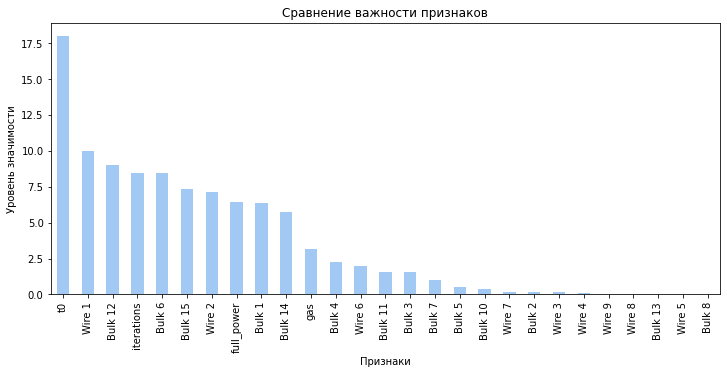

In [42]:
fi = pd.Series(cb_model.feature_importances_, index=features.columns)
fi = fi.sort_values(ascending=False)
plt.figure(figsize=(12,5))
ax = fi.plot(kind='bar')
ax.set_title('Сравнение важности признаков')
ax.set_ylabel('Уровень значимости')
ax.set_xlabel('Признаки');

## Вывод
На этапе анализа и обработки данных, мы оставили только те партии, по которым была предоставлена полная информация и эта информация не содержала аномилий. Финальная выборка состоит из 2309 строк. Обучены 3 разные модели и выбрана наилучшая - Catboost. На тестовой выборке модель показала результат удовлетворяющий требованию MAE < 6.8.  


Самым важным фактором, для предсказания конечной температуры, является начальная температура. Вторые по важности факторы: Bilk 14, full_power, Bulk 15, Wire 2, gas, Bulk 6, Bulk 12, iterations, Bulk 3,1 и 4. Остальные факторы не оказывают существенного влияния на конечную температуру.

## Отчёт

В ходе работы над проектом были выполнены шаги:
1. Анализ данных - изучены распределение, аномалии и пропуски в данных.
2. Предобработка данных - удалены аномалии, партии без данных, коррелирующие признаки.
3. Обучение модели - обучены несколько моделей, с перебором гиперпараметров.
4. Тестирование модели - лучший результат на обучающих данных показала модель CatBoost. Её результат на тестовой выборке MAE: 6.777

В ходе анализа были были выявлены выбросы, природу которых было трудно определить без консультации с заказчиком. После удаления выбросов упало качество модели и потребовалось дополнить набор признаков. Агрегация данных по партии.

Ключевые действия в работе над проектом: 
- Изучить предметную область
- Изучить тех процесс
- Прояснить у заказчика цель проекта
- Прояснить у заказчика причину выбросов
- Добавить признаки (Итоговая мощность, количество итераций, время работы электродов)

Признаки, на которых обучалась итоговая модель:
- `full_power`
- `iterations`
- `Bulk 1`
- `Bulk 2`
- `Bulk 3`
- `Bulk 4`
- `Bulk 5`
- `Bulk 6`
- `Bulk 7`
- `Bulk 8`
- `Bulk 9`
- `Bulk 10`
- `Bulk 11`
- `Bulk 12`
- `Bulk 13`
- `Bulk 14`
- `Bulk 15`
- `gas`
- `t0`
- `Wire 1`
- `Wire 2`
- `Wire 3`
- `Wire 4`
- `Wire 5`
- `Wire 6`
- `Wire 7`
- `Wire 8`
- `Wire 9`

В каждом признаке были выброшены аномалии, но сохранены выбросы. 
Стоит учесть, что только следующий признаки оказали существенное влияние на работу модели: `Bulk 14, full_power, Bulk 15, Wire 2, gas, Bulk 6, Bulk 12, iterations, Bulk 3,1 и 4.`. 

Гиперпараметры модели: `{'min_data_in_leaf': 50, 'depth': 5, 'iterations': 600, 'learning_rate': 0.008}`, random_state: `10923`


Для улучшения качества модели в первую очередь нужно собрать большее количество данных, на втором месте по важности стоит качество данных. Возможно стоит пересмотреть целевой признак, например предсказывать не температуру, а количество затраченной энергии. Я думаю, что верный признак можно определить в процессе эксплуатации модели.